# Tutorial #6: Applying Machine Learning Methods to Temporal Dimensions of EEG Data

In this tutorial, we will apply classification on the same EEG data as in the previous cases, [Single-Paricipant Analysis](ApplyingMachineLearningMethods_1.ipynb) and [Group-Level Analysis](ApplyingMachineLearningMethods_2.ipynb), but taking advantage of the temporal dimension of the data.

In the previous tutorials ([Single-Paricipant Analysis](ApplyingMachineLearningMethods_1.ipynb) and [Group-Level Analysis](ApplyingMachineLearningMethods_2.ipynb)) we examined whether it is possible to classify EEG responses to different stimuli, at all. However, the classification was agnostic of time. It just informed that somewhere in the brain, at some point in time, there were differential EEG responses to different stimuli (to check).

Here, we go one step further, and ask the questions:
* (a) Can we classify EEG resposnes to different images?
* (b) When in time is there discriminant EEG activity?

To answer these questions, we will use the same algorithms as in the previous tutorials ([Single-Paricipant Analysis](ApplyingMachineLearningMethods_1.ipynb) and [Group-Level Analysis](ApplyingMachineLearningMethods_2.ipynb))), but this time, we will train one classifier at each time instance and we will evaluate the performance of the model at each time instance in new epochs. 

The function [SlidingEstimator](https://mne.tools/dev/generated/mne.decoding.SlidingEstimator.html) in MNE package is provided for this purpose. This takes the model and optionally a scoring function as parameters to create a time-point by time-point classifier. After having created a sliding estimator, it can be fitted to the data, scored the estimator on each task or made predictions on new epochs.

In [1]:
# To silence the warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import mne

from mne.decoding import SlidingEstimator, cross_val_multiscore, CSP, Vectorizer
from mne import Epochs, events_from_annotations, pick_types
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf

from os.path import isfile, join
from os import listdir
import numpy as np
import statistics

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import  ShuffleSplit, cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Models
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

## Analysis on temporal dimensions for each participant separately


1. Prepare data for the analysis

In [4]:
print(__doc__)

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1.0, 4.0
event_id = dict(hands=2, feet=3)
subject_id = [1,2,3,4,5,6,7,8]
runs = [6, 10, 14]  # motor imagery: hands vs feet

epochs_data, epochs_all, labels =[],[],[]
for no,name in enumerate(subject_id):
    raw_fnames = eegbci.load_data(subject_id[no], runs)
    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
    eegbci.standardize(raw)  # set channel names
    montage = make_standard_montage("standard_1005")
    raw.set_montage(montage)

    # Apply band-pass filter
    raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

    events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

    # Read epochs (train will be done only between 1 and 2s)
    # Testing will be done with a running classifier
    epochs = Epochs(
        raw,
        events,
        event_id,
        tmin,
        tmax,
        proj=True,
        picks=picks,
        baseline=None,
        preload=True,
    )
    epochs_all.append(epochs)
    data_all = epochs.get_data(copy=False)
    epochs_data.append(data_all)
    label = epochs.events[:, -1] - 2
    labels.append(label)

Automatically created module for IPython interactive environment
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal ba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Download complete in 19s (7.3 MB)
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Download complete in 20s (7.3 MB)
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped


Download complete in 18s (7.4 MB)
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped


Download complete in 18s (7.3 MB)
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/tivadarr/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


2. Train classifiers with sliding window estimator on data of each participant separately and apply 3-fold cross validation.

In [5]:
def applyCrossValidation(data, labels, epochs, ids, classifier):
    CV_score_time = None
    sl = SlidingEstimator(classifier, scoring='accuracy') 
    if np.isfinite(data).all() == True and np.isnan(data).any() == False:
        CV_score_time = cross_val_multiscore(sl, data, labels, cv=3)
        plotCVScores(epochs.times, CV_score_time, ids)
    else:
        print('Input contains NaN or infinity!')
    return CV_score_time

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotCVScores(times, CV_score_time, id=None):
    fig, ax = plt.subplots()
    if id != None:
        fig.suptitle('CV Scores of Participant-'+str(id))
    else:
        fig.suptitle('CV Scores')  
    ax.plot(times, CV_score_time.T)
    plt.xlabel('Time')
    plt.ylabel('CV Accuracy')
    plt.show()

In [7]:
np.shape(epochs_data[0])

(45, 64, 801)

In [8]:
np.shape(epochs_data)

((8, 45, 64, 801), (45, 64, 801))

# Classification Between Hand and Foot motor imagery 


Participant id: 1


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  391.42it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:01<00:00,  408.48it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:01<00:00,  429.55it/s]


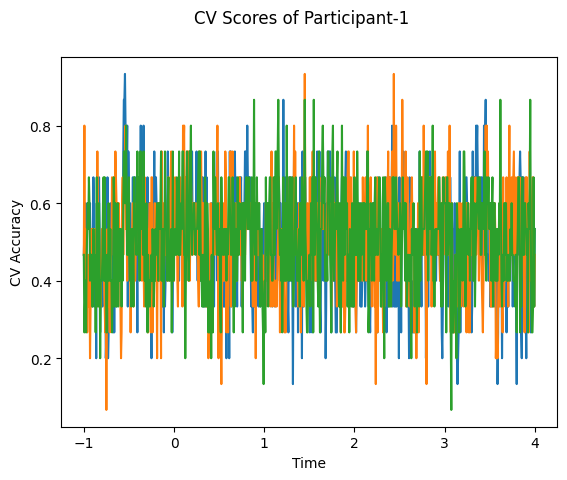

Participant id: 2


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  390.50it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  355.79it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  389.09it/s]


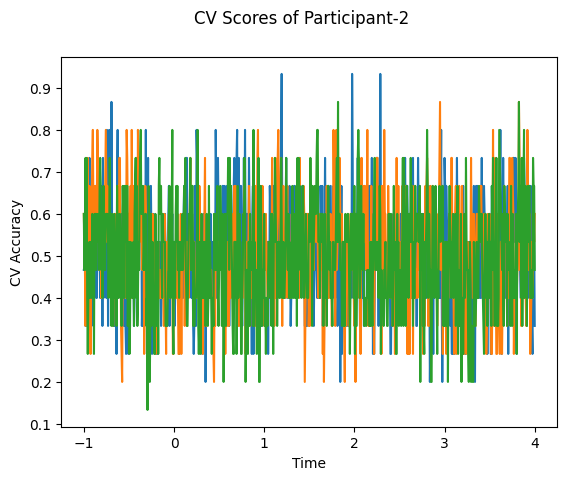

Participant id: 3


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  398.68it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:01<00:00,  436.07it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  386.24it/s]


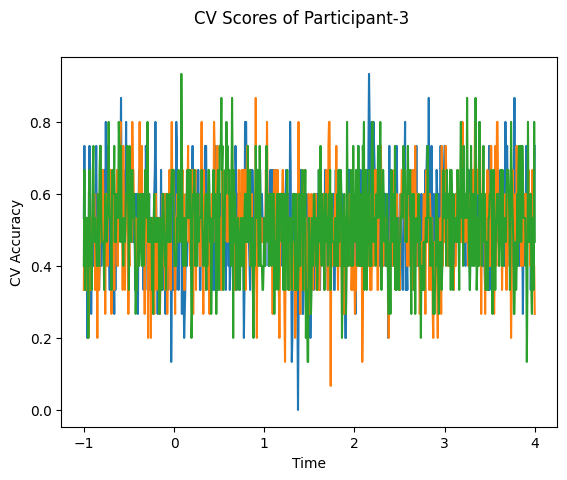

Participant id: 4


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  349.70it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  359.20it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  353.51it/s]


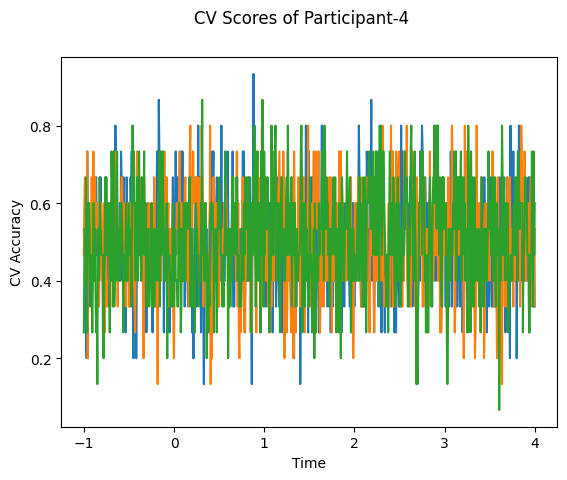

Participant id: 5


100%|████████████| Fitting SlidingEstimator : 801/801 [00:01<00:00,  418.61it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:01<00:00,  416.41it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:01<00:00,  444.66it/s]


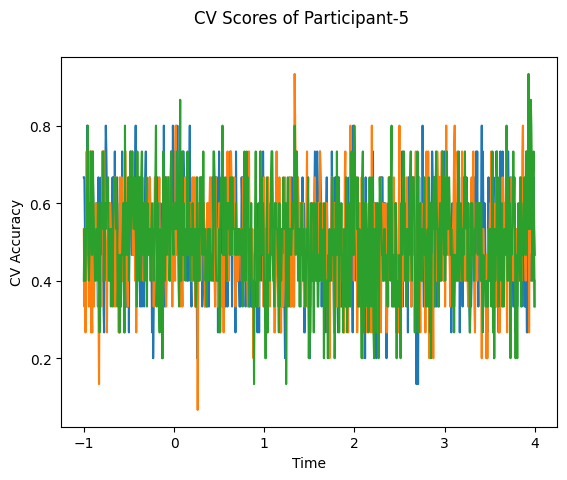

Participant id: 6


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  382.07it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  361.75it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  395.91it/s]


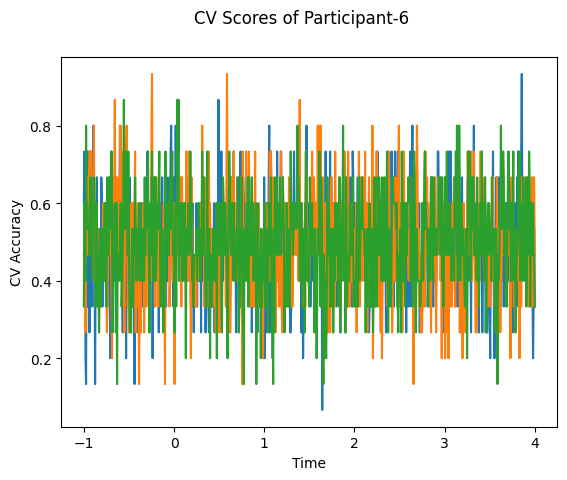

Participant id: 7


100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  318.24it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  342.83it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:02<00:00,  308.20it/s]


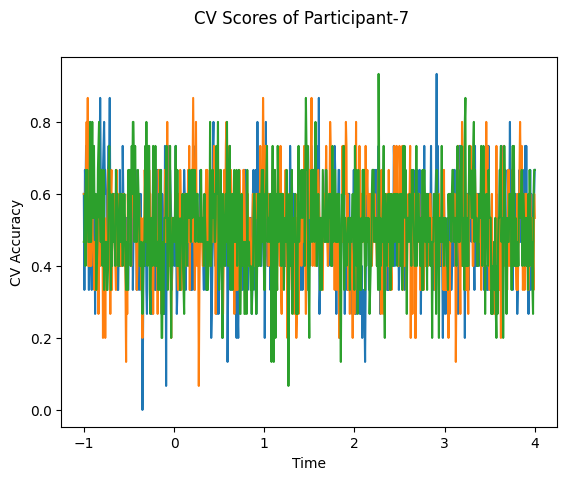

Participant id: 8


100%|████████████| Fitting SlidingEstimator : 801/801 [00:03<00:00,  242.12it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:03<00:00,  241.66it/s]
100%|████████████| Fitting SlidingEstimator : 801/801 [00:03<00:00,  226.74it/s]


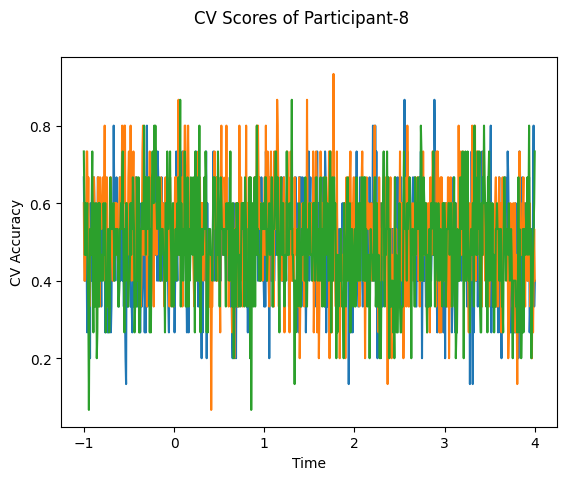

In [10]:
CV_score_time_img = []
for i in range(len(epochs_data)):
    print('Participant id: '+ str(subject_id[i]))
    clf = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
    CV_score_time_img.append(applyCrossValidation(epochs_data[i], labels[i], epochs_all[i], subject_id[i], clf))

In [ ]:
def averageCVScores(CV_score_time):
    avg_cv_scores = []
    for cv in CV_score_time:
        avg_scores_tmp = []
        sum_col_wise = cv.sum(axis=0)
        avg_scores_tmp = [s/len(cv) for s in sum_col_wise]
        avg_cv_scores.append(avg_scores_tmp)
    return avg_cv_scores

In [ ]:
avg_cv_score_time = averageCVScores(CV_score_time_img)

The following cell plots the mean and standard deviation of cross validation accuracies of participants.

In [ ]:
import pylab, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import ttest_rel, sem

def plot_conditions(data,epochs,labels):

    sns.set(style="white")
    ColorsL = np.array(([228,26,28], [55,126,184], [77,175,74], [152,78,163], [255,127,0]))/256
    col_axes = np.array((82, 82, 82))/256

    al = 0.2
    fig = plt.figure(num=None, figsize=(4, 2), dpi=150)

    
    epochs_mean = np.mean(data, axis = 0)
    epochs_std = sem(data, axis = 0)/2

    plt.plot(epochs[0].times, epochs_mean, color = ColorsL[0], linewidth = 0.5, label = labels)
    plt.fill_between(epochs[0].times, epochs_mean, epochs_mean + epochs_std, color = ColorsL[0], interpolate=True, alpha = al)
    plt.fill_between(epochs[0].times, epochs_mean, epochs_mean - epochs_std, color = ColorsL[0], interpolate=True, alpha = al)
    plt.ylabel('Mean CV Accuracy')
    plt.xlabel('Times')

Mean cross validation accuracy plot below is showing that above chance (50%) accuracy achived at each time points. 

In [ ]:
avg_cv_score_time = np.asarray(avg_cv_score_time)
plot_conditions(avg_cv_score_time,epochs, labels)

3. Train classifiers on full epoch 

In [ ]:
def applyCrossValidation_ep(clf, data,labels, epochs, ids, classifier):
    CV_score = None
    if np.isfinite(data).all() == True and np.isnan(data).any() == False:
        CV_score= cross_val_multiscore(clf, data, labels, cv=3)
    else:
        print('Input contains NaN or infinity!')
    return CV_score

In [ ]:
CV_score_img = []
for i in range(len(epochs_data)):
    print('Participant id: '+ str(subject_ids[i]))
    clf = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
    CV_score_img.append(applyCrossValidation_ep(clf,epochs_data[i], labels[i], epochs_all[i], subject_ids[i], clf))
    print(np.mean(CV_score_img))

How do you improve the results?

# Group-Level Analysis on Temporal Dimension



As in the previous tutorial ([Group-Level Analysis](ApplyingMachineLearningMethods_2.ipynb)) , participants' data are concatenated for forming the dataset required for group-level analysis.  

After having the dataset; data, labels and ids(participant ids) are separated by the folowing function.

In [ ]:
def getData_labels(epochs):
    data, labels, ids = [], [], []
    for p in epochs:
        tmp_epoch = p[1]
        tmp_labels = tmp_epoch.events[:,-1] -2
        labels.extend(tmp_labels)
        tmp_id = p[0]
        ids.extend([tmp_id]*len(tmp_labels))        
        data.extend(tmp_epoch.get_data())
        
    data = np.array(data)
    labels = np.array(labels)
    ids = np.array(ids)
    return data, labels, ids

### Task #1: Classification of Unpleasant and Pleasant Events

Before starting the model building phase, data should be checked if it contains an invalid value which can be plus/minus infinite or NaN because python's sklearn package cannot handle those values while building models. If the following cell returns "Nan or inifinite is detedted!", you need to check your dataset before moving the next step.
Note that, it may occur that the data contains no NaN or infinite value but sklearn may still give error claiming the opposite. The reason for this error is that there are some values in your dataset which have higher precision than float64 or float32 (depending your preferance while reading data at the beginning) can handle. To fix this issue you can cast your values to float64 or float32 while reading the dataset.

In [ ]:
#Preparing dataset
data_gr, labels_gr, ids_gr = getData_labels(epochs_all)
if np.isfinite(data_gr).all() == True and np.isnan(data_gr).any() == False:
    print('Data does not contain nan or infinite value')
else:
    print('Nan or inifininte is detected!')

In [ ]:
labels_gr

In [ ]:
clf_gr = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
sl_gr = SlidingEstimator(clf_gr, scoring='accuracy') 
if np.isfinite(data_gr).all() == True and np.isnan(data_gr).any() == False:
    CV_score_time = cross_val_multiscore(sl_gr, data_gr, labels_gr, cv=3)
    print('Cross validation scores:\n {}'.format(CV_score_time))
else:
    print('Input contains NaN or infinity!')

In [ ]:
plotCVScores(epochs_UP.times, CV_score_time)

Note that hyper-parameter optimization is not applied due to the computation time constraints and left as an exercise.

The above three plots show the mean cross validation accuracy over time for each classification task. The accuracies are less than 50% for all time points meaning that models do not perform above chance. In contrast to the group-level cross validation plots, the mean of cross validation scores for all participants over time is higer than 50%. So, we may conclude that high variation between participants leads to poor performance on group-level. 